# Dati ARPA

In [6]:
import sqlite3
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

## Conversione delle tabelle del database in dataframe

In [7]:
def get_dataframe(table_name):
    conn = sqlite3.connect('arpa.db')
    query = f'SELECT * FROM {table_name}'
    df = pd.read_sql_query(query, conn)
    conn.close()
    return df

## Dataframe delle rilevazioni di certi pollutants, in certe stazioni nell'intervallo dato 

In [8]:
def get_measurements(start_date, end_date, station_ids, pollutants):
    conn = sqlite3.connect('arpa.db')
    cursor = conn.cursor()

    query = '''
    SELECT * FROM measurements
    WHERE data_rilevazione BETWEEN ? AND ?
    AND id_station IN ({})
    AND inquinante_misurato IN ({})
    ORDER BY id_station, inquinante_misurato
    '''.format(','.join(['?']*len(station_ids)), ','.join(['?']*len(pollutants)))

    cursor.execute(query, [start_date, end_date] + station_ids + pollutants)
    rows = cursor.fetchall()

    column_names = [description[0] for description in cursor.description]

    conn.close()

    df = pd.DataFrame(rows, columns=column_names)
    return df

## Grafico dell'andamento delle rilevazioni 

In [9]:
def plot_measurements(df, pollutants_df):
    conn = sqlite3.connect('arpa.db')
    
    query = "SELECT id_station, denominazione FROM stations"
    stations_df = pd.read_sql_query(query, conn)
    conn.close()
    
    station_names = dict(zip(stations_df['id_station'], stations_df['denominazione']))
    
    stations = df['id_station'].unique()
    pollutants = df['inquinante_misurato'].unique()

    for station in stations:
        for pollutant in pollutants:
            filtered_df = df[(df['id_station'] == station) & (df['inquinante_misurato'] == pollutant)]

            limit_row = pollutants_df[pollutants_df['inquinante_misurato'] == pollutant]
            if len(limit_row) > 0:
                limit = limit_row['limite'].iloc[0]
            else:
                limit = None

            # Grafico
            plt.figure(figsize=(10, 6))
            sns.lineplot(x='data_rilevazione', y='valore_inquinante_misurato', data=filtered_df, marker='o', label='Valore misurato')

            # Barra orizzontale che evidenzia il valore limite
            if limit is not None:
                plt.axhline(y=limit, color='r', linestyle='--', label='Limite')

            # Titolo con il nome della stazione
            station_name = station_names.get(station, f"ID Stazione {station}")
            plt.title(f'Andamento del valore misurato per {pollutant} nella stazione {station_name}')
            plt.xlabel('Data rilevazione')
            plt.ylabel('Valore misurato')
            plt.legend()

            plt.xticks(rotation=45)
            plt.tight_layout()
            plt.show()

# Visualizzazione dei dati

In [19]:
conn = sqlite3.connect('arpa.db')

In [20]:
stations_df = get_dataframe('stations')
pollutants_df = get_dataframe('pollutants')
measurements_df = get_dataframe('measurements')

In [21]:
stations_df

,id_station,denominazione,coordinates,rete,interesse_rete,tipologia_stazione,tipologia_area,comune,provincia,paese,paese_esteso
0,64,Altamura - Via Santeramo,"[16.561014, 40.82885]",RRQA,PUBBLICO,Fondo,Suburbana,Altamura,Bari,IT,Italy
1,17,Bari - Caldarola,"[16.888063, 41.11354]",RRQA,PUBBLICO,Traffico,Urbana,Bari,Bari,IT,Italy
2,81,Bari - Carbonara,"[16.866943, 41.076668]",RRQA,PUBBLICO,Fondo,Suburbana,Bari,Bari,IT,Italy
3,54,Bari - Cavour,"[16.872553, 41.12227]",RRQA,PUBBLICO,Traffico,Urbana,Bari,Bari,IT,Italy
4,90,Bari - CUS,"[16.845278, 41.134724]",RRQA,PUBBLICO,Traffico,Suburbana,Bari,Bari,IT,Italy
...,...,...,...,...,...,...,...,...,...,...,...
63,19,Taranto - Archimede,"[17.233047, 40.494442]",RRQA,PUBBLICO,None,None,Taranto,Taranto,IT,Italy
64,37,Taranto - CISI,"[17.253416, 40.520935]",RRQA,PUBBLICO,Industriale,Rurale,Taranto,Taranto,IT,Italy
65,20,Taranto - Machiavelli,"[17.225822, 40.48861]",RRQA,PUBBLICO,None,None,Taranto,Taranto,IT,Italy
66,21,Taranto - San Vito,"[17.225271, 40.42333]",RRQA,PUBBLICO,None,None,Taranto,Taranto,IT,Italy


In [22]:
pollutants_df

,inquinante_misurato,limite,unita_misura
0,NO2,200.0,µg/m³
1,O3,180.0,µg/m³
2,PM10,50.0,µg/m³
3,PM2.5,25.0,µg/m³
4,C6H6,5.0,µg/m³
5,CO,10.0,mg/m³
6,IPA,NaN,ng/m³
7,H2S,NaN,µg/m³
8,SO2,350.0,µg/m³
9,BLACK CARB,NaN,ng/m³


In [23]:
measurements_df

,data_rilevazione,inquinante_misurato,id_station,valore_inquinante_misurato,superamenti,indice_qualita,responsabile_dato,punto_di_contatto,sorgente,marker_color
0,2024-05-22,NO2,64,32.0,0.0,16.0,Arpa Puglia - Direzione Scientifica - Centro R...,Arpa Puglia - Sistemi Informativi,ARPAP,#00ffff
1,2024-05-22,O3,64,102.0,0.0,57.0,Arpa Puglia - Direzione Scientifica - Centro R...,Arpa Puglia - Sistemi Informativi,ARPAP,#9acc00
2,2024-05-22,PM10,64,15.0,2.0,30.0,Arpa Puglia - Direzione Scientifica - Centro R...,Arpa Puglia - Sistemi Informativi,ARPAP,#00ffff
3,2024-05-22,PM2.5,64,7.0,1.0,28.0,Arpa Puglia - Direzione Scientifica - Centro R...,Arpa Puglia - Sistemi Informativi,ARPAP,#00ffff
4,2024-05-22,C6H6,17,0.1,0.0,2.0,Arpa Puglia - Direzione Scientifica - Centro R...,Arpa Puglia - Sistemi Informativi,ARPAP,#00ffff
...,...,...,...,...,...,...,...,...,...,...
2794,2024-06-03,IPA,38,NaN,0.0,NaN,Arpa Puglia - Direzione Scientifica - Centro R...,Arpa Puglia - Sistemi Informativi,ARPAP,#ffffff
2795,2024-06-03,NO2,38,NaN,0.0,NaN,Arpa Puglia - Direzione Scientifica - Centro R...,Arpa Puglia - Sistemi Informativi,ARPAP,#ffffff
2796,2024-06-03,O3,38,NaN,0.0,NaN,Arpa Puglia - Direzione Scientifica - Centro R...,Arpa Puglia - Sistemi Informativi,ARPAP,#ffffff
2797,2024-06-03,PM10,38,NaN,0.0,NaN,Arpa Puglia - Direzione Scientifica - Centro R...,Arpa Puglia - Sistemi Informativi,ARPAP,#ffffff


In [24]:
start_date = '2024-05-01'
end_date = '2024-06-30'
station_ids = ['17', '81']
pollutants = ['NO2', 'O3', 'PM10']
target_measurements_df = get_measurements(start_date, end_date, station_ids, pollutants)

In [25]:
target_measurements_df

,data_rilevazione,inquinante_misurato,id_station,valore_inquinante_misurato,superamenti,indice_qualita,responsabile_dato,punto_di_contatto,sorgente,marker_color
0,2024-05-22,NO2,17,29.0,0,15.0,Arpa Puglia - Direzione Scientifica - Centro R...,Arpa Puglia - Sistemi Informativi,ARPAP,#00ffff
1,2024-05-23,NO2,17,34.0,0,17.0,Arpa Puglia - Direzione Scientifica - Centro R...,Arpa Puglia - Sistemi Informativi,ARPAP,#00ffff
2,2024-05-25,NO2,17,NaN,0,NaN,Arpa Puglia - Direzione Scientifica - Centro R...,Arpa Puglia - Sistemi Informativi,ARPAP,#ffffff
3,2024-05-26,NO2,17,33.0,0,17.0,Arpa Puglia - Direzione Scientifica - Centro R...,Arpa Puglia - Sistemi Informativi,ARPAP,#00ffff
4,2024-05-27,NO2,17,39.0,0,20.0,Arpa Puglia - Direzione Scientifica - Centro R...,Arpa Puglia - Sistemi Informativi,ARPAP,#00ffff
5,2024-05-28,NO2,17,35.0,0,18.0,Arpa Puglia - Direzione Scientifica - Centro R...,Arpa Puglia - Sistemi Informativi,ARPAP,#00ffff
6,2024-05-30,NO2,17,58.0,0,29.0,Arpa Puglia - Direzione Scientifica - Centro R...,Arpa Puglia - Sistemi Informativi,ARPAP,#00ffff
7,2024-06-02,NO2,17,NaN,0,NaN,Arpa Puglia - Direzione Scientifica - Centro R...,Arpa Puglia - Sistemi Informativi,ARPAP,#ffffff
8,2024-06-03,NO2,17,NaN,0,NaN,Arpa Puglia - Direzione Scientifica - Centro R...,Arpa Puglia - Sistemi Informativi,ARPAP,#ffffff
9,2024-05-22,PM10,17,14.0,3,28.0,Arpa Puglia - Direzione Scientifica - Centro R...,Arpa Puglia - Sistemi Informativi,ARPAP,#00ffff


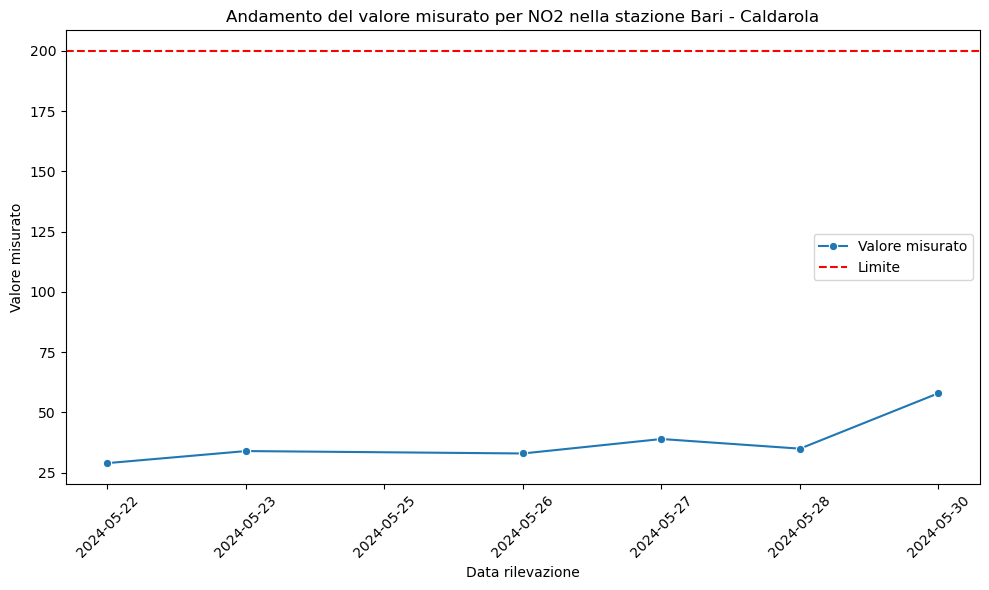

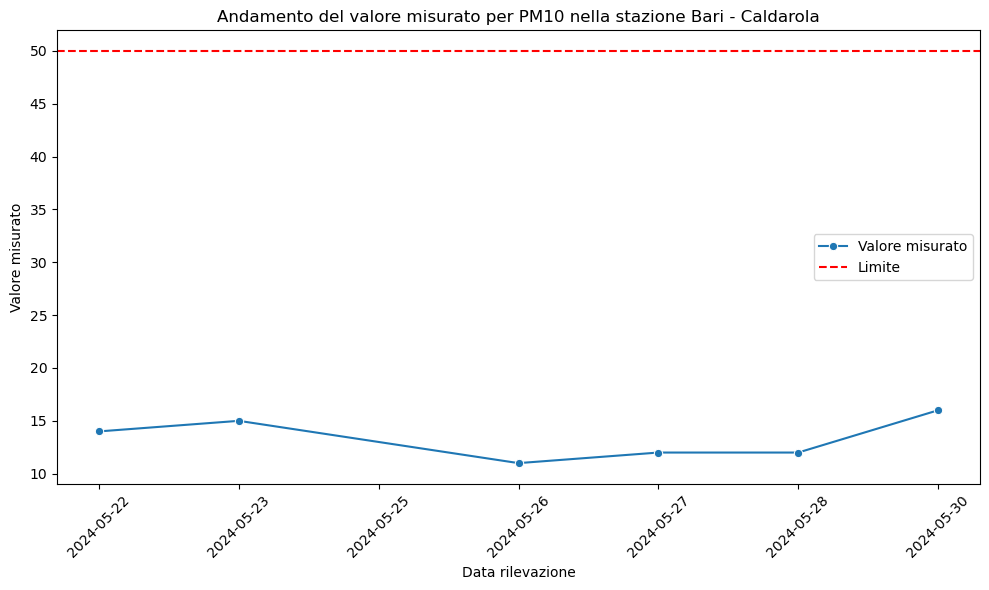

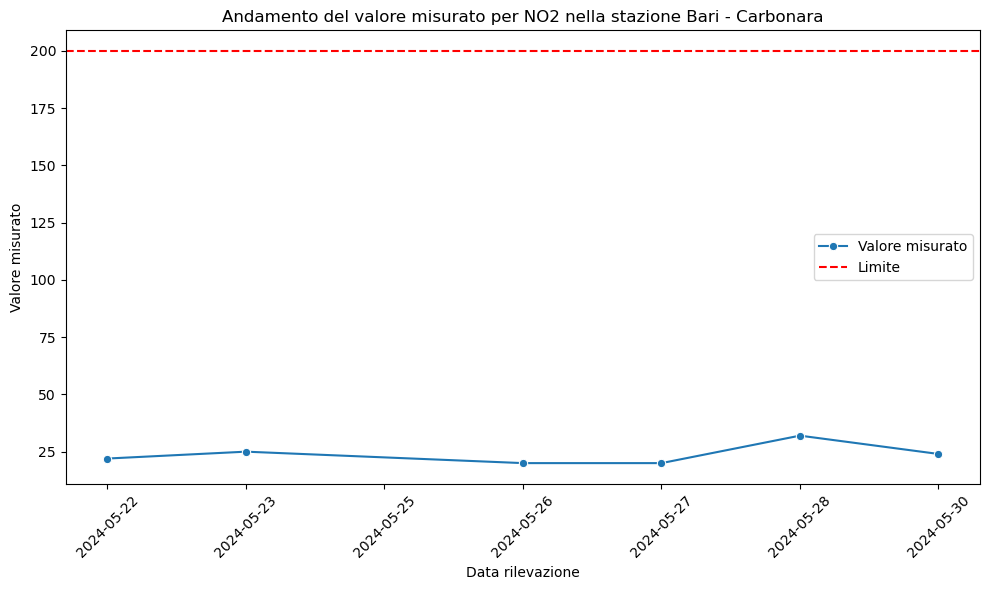

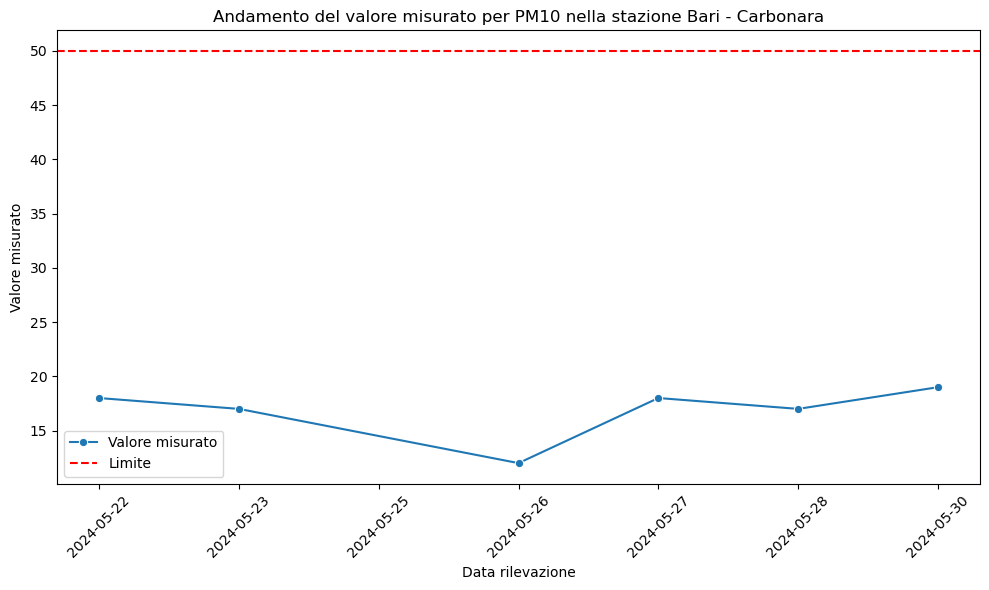

In [26]:
plot_measurements(target_measurements_df, pollutants_df)

In [18]:
conn.close()